<a href="https://colab.research.google.com/github/number1angel/tphotel/blob/juli-lol/ML_proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hotel Booking Demand — Trabajo Final CD 2025**

# **1) Imports básicos**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    accuracy_score
)

# **2) Estilo global para los graficos**

In [2]:
sns.set_theme(style="whitegrid")

# **3) Cargar dataset**

In [3]:
df = pd.read_csv("hotel_bookings_demand_TF.csv")
print("Dimensiones originales:", df.shape)

Dimensiones originales: (119390, 32)


# **4) Exploración rápida**

In [29]:
display(df.head())
print("Porcentaje de valores faltantes por columna:")
display((df.isnull().mean()*100).sort_values(ascending=False).head(10))

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342.0,2015.0,July,NaN,1,0,0,2,...,0,C,C,3,No Deposit,0,Transient,0.0,0,0
1,Resort Hotel,0,737.0,2015.0,July,27.0,1,0,0,2,...,0,C,C,4,No Deposit,0,Transient,0.0,0,0
2,Resort Hotel,0,7.0,2015.0,July,27.0,1,0,1,1,...,0,A,C,0,No Deposit,0,Transient,75.0,0,0
3,Resort Hotel,0,13.0,2015.0,July,27.0,1,0,1,1,...,0,A,A,0,No Deposit,0,Transient,75.0,0,0
4,Resort Hotel,0,14.0,2015.0,July,27.0,1,0,2,2,...,0,A,A,0,No Deposit,0,Transient,98.0,0,1


Porcentaje de valores faltantes por columna:


,0
arrival_date_week_number,10.000000
arrival_date_year,4.999581
is_canceled,0.000000
hotel,0.000000
lead_time,0.000000
arrival_date_month,0.000000
arrival_date_day_of_month,0.000000
stays_in_weekend_nights,0.000000
stays_in_week_nights,0.000000
adults,0.000000


### **Cuántos valores faltantes tiene c/columna, ordenados de mayor a menor**

In [37]:
df.isnull().sum().sort_values(ascending=False)

,0
arrival_date_week_number,11939
arrival_date_year,5969
is_canceled,0
hotel,0
lead_time,0
arrival_date_month,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


# **5) Gráficos de EDA obligatorios**

### **a) Boxplot de lead_time por is_canceled**

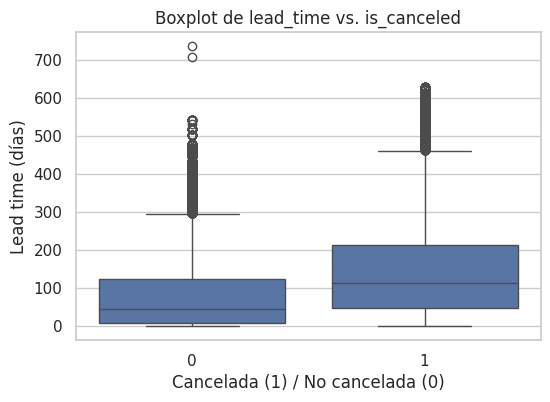

In [5]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="is_canceled", y="lead_time")
plt.title("Boxplot de lead_time vs. is_canceled")
plt.xlabel("Cancelada (1) / No cancelada (0)")
plt.ylabel("Lead time (días)")
plt.show()

### **b) Violin plot de lead_time por is_canceled**

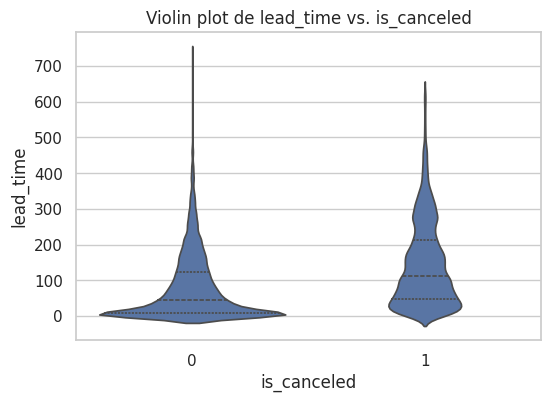

In [9]:
plt.figure(figsize=(6,4))
sns.violinplot(data=df, x="is_canceled", y="lead_time", inner="quartile")
plt.title("Violin plot de lead_time vs. is_canceled")  # NOTA OBLIGATORIA
plt.show()

### **c) Heatmap de correlaciones entre variables continuas**

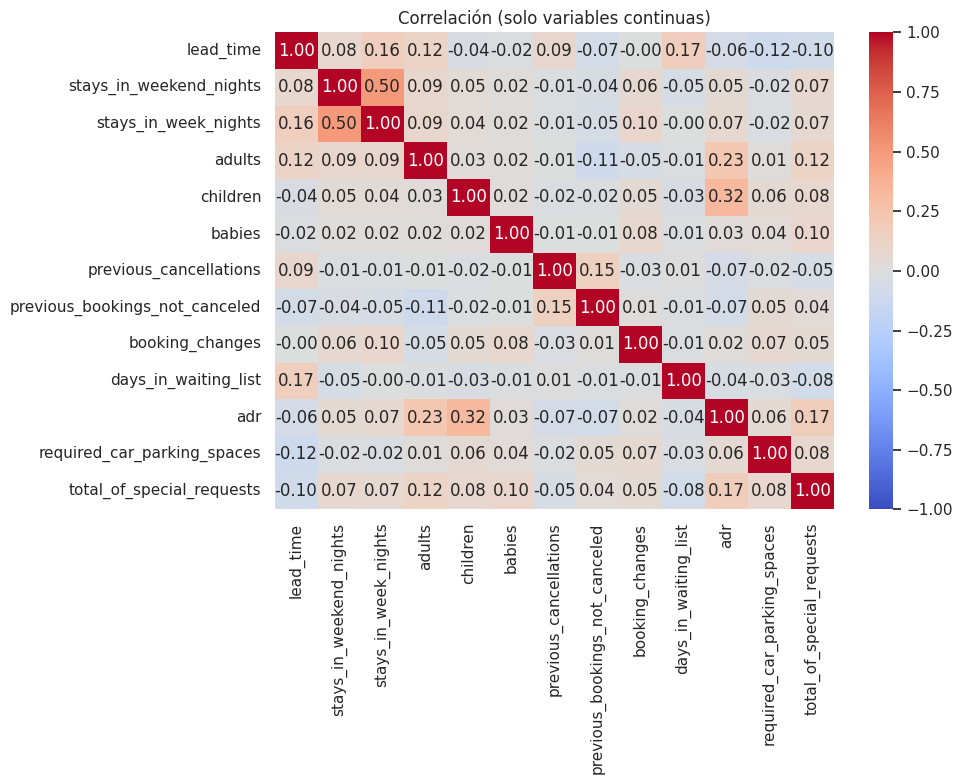

In [7]:
cont_cols = [
    'lead_time','stays_in_weekend_nights','stays_in_week_nights',
    'adults','children','babies','previous_cancellations',
    'previous_bookings_not_canceled','booking_changes',
    'days_in_waiting_list','adr','required_car_parking_spaces',
    'total_of_special_requests'
]
plt.figure(figsize=(10,8))
sns.heatmap(df[cont_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlación (solo variables continuas)")  # NOTA OBLIGATORIA
plt.tight_layout()
plt.show()

# **6) Limpieza y selección de variables**

### **6.1) Eliminar columnas irrelevantes o con demasiada cardinalidad**

In [8]:
drop_cols = [
    # ➞ Estado y fecha de estado de la reserva
    #   "reservation_status" indica si la reserva ya fue “Canceled” o
    #   “Check-In”—¡es literalmente tu variable objetivo en bruto!
    #   Y “reservation_status_date” te dice el momento exacto en que
    #   se canceló o se hizo check-in. Con eso tu modelo tendría
    #   acceso directo a la respuesta en el momento de entrenar.
    'reservation_status_date',   # fecha de último cambio de estado
    'reservation_status',        # lo mismo que is_canceled + detalles
    # ➞ Año, semana y día de llegada
    #   Estos tres juntos te dicen exactamente CUÁNDO llega el huésped. Si por ej filtras por año o día específico, el modelo podría aprender
    # directamente patrones temporales (alto riesgo de sobreajuste) o incluso “aprender” que en ciertos meses no se cancelan nunca. No aportan información generalizable.
    'arrival_date_year',
    'arrival_date_week_number',
    'arrival_date_day_of_month',
    'agent',                     # demasiadas categorías únicas
    'company',                   # idem
    'country'                    # opcionalmente, imputar MISSING en lugar de codificar miles de países
]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

### **6.2) Tratar faltantes**

children y babies suelen tener unos pocos nulls: los ponemos a 0

In [11]:
df['children'] = df['children'].fillna(0) #ausencia de dato como “no hay niños” en la reserva.
df['babies']   = df['babies'].fillna(0) #Para las categóricas, usamos valor especial en vez de borrarlas. Así puede aprender “país desconocido” como una categoría más.

Para ADR y lead_time (numéricas), imputar por media

In [13]:
df['lead_time'] = df['lead_time'].fillna(df['lead_time'].mean())  #media.Estrategia p/variables num continuas, mantiene la tendencia central sin distorsionar drásticamente su distribución.
df['adr']       = df['adr'].fillna(df['adr'].mean())

### **6.3) Eliminar variables constantes o casi constantes**

In [14]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns
vt = VarianceThreshold(threshold=0.01)
vt.fit(df[num_cols])
low_var = num_cols[~vt.get_support()]
print("Columnas de muy baja varianza eliminadas:", list(low_var))
df.drop(columns=low_var, inplace=True)

Columnas de muy baja varianza eliminadas: ['babies']


### **6.5) Separar target y features**

In [15]:
y = df['is_canceled']
X = df.drop(columns=['is_canceled']) #quitamos 'is_canceled' porque es lo que queremos predecir

# **7) Definir pipelines**

### **7.1) Numéricas**

In [26]:
num_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")), # Imputa NaN con la media
    ("scaler", StandardScaler()) # Luego estandariza (media=0, std=1)
])
print(num_features)

['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


### **7.2) Categóricas**

In [25]:
cat_features = X.select_dtypes(include=["object","category"]).columns.tolist()
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),  # Rellena NaN con la etiqueta "MISSING"
    ("onehot", OneHotEncoder(handle_unknown="ignore")) # Luego aplica one-hot encoding
])
print(cat_features)

['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']


### **7.3) Preprocessor**

In [24]:
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features), # a estas columnas aplícales el pipeline numérico
    ("cat", categorical_pipeline, cat_features) # a estas otras, el pipeline categórico
])

# **8) Modelos**

## **10.1) Regresión Logística**

=== Regresión Logística ===
Accuracy: 0.8109756097560976
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     18792
           1       0.83      0.61      0.71     11056

    accuracy                           0.81     29848
   macro avg       0.82      0.77      0.78     29848
weighted avg       0.81      0.81      0.80     29848



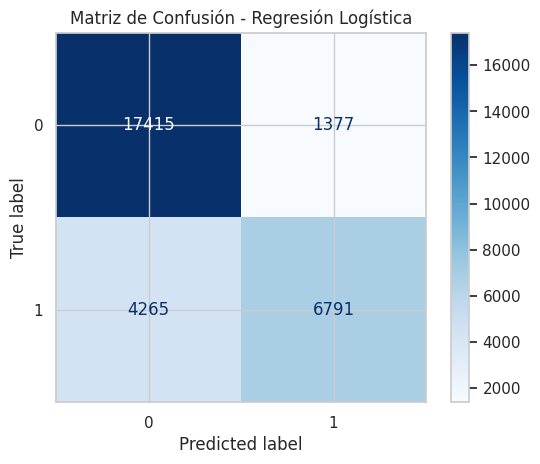

In [27]:
logreg = LogisticRegression(max_iter=200, solver='liblinear', random_state=42)
clf_logreg = Pipeline([
    ("prep", preprocessor),
    ("clf", logreg)
])
clf_logreg.fit(X_train, y_train)
y_pred_lr = clf_logreg.predict(X_test)
print("=== Regresión Logística ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
ConfusionMatrixDisplay.from_estimator(clf_logreg, X_test, y_test, cmap="Blues")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

## **10.2) Random Forest**

=== Random Forest ===
Accuracy: 0.8152975073706781
              precision    recall  f1-score   support

           0       0.79      0.96      0.87     18792
           1       0.90      0.56      0.69     11056

    accuracy                           0.82     29848
   macro avg       0.85      0.76      0.78     29848
weighted avg       0.83      0.82      0.80     29848



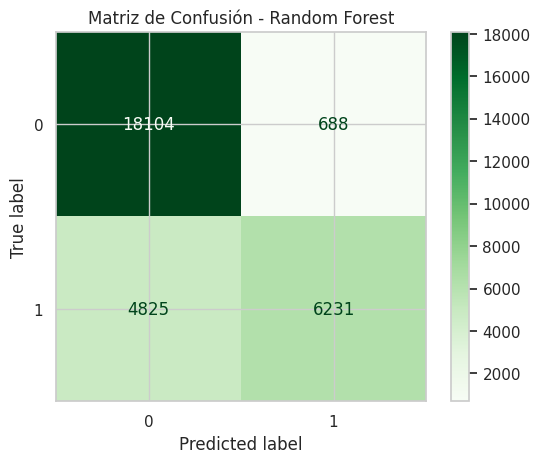

In [28]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
clf_rf = Pipeline([
    ("prep", preprocessor),
    ("clf", rf)
])
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_estimator(clf_rf, X_test, y_test, cmap="Greens")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# **17) Feature Importances de Random Forest**


/tmp/ipython-input-36-1726643920.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df, x="importance", y="feature", palette="magma")


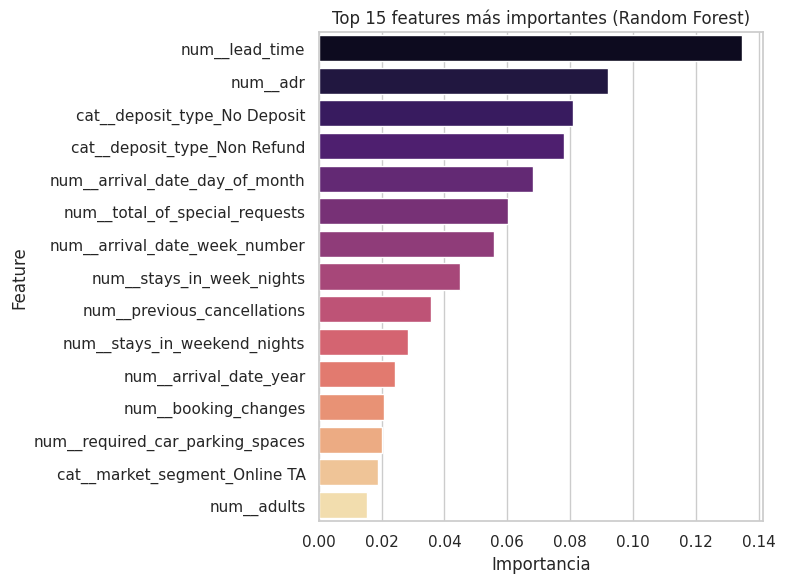

In [36]:
pipe_rf = Pipeline([
    ("pre", preprocessor),  # tu ColumnTransformer ya creado
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# Entrena el pipeline
pipe_rf.fit(X_train, y_train)

# B) Extrae los nombres de todas las columnas tras el preprocesamiento
feat_names = pipe_rf.named_steps["pre"].get_feature_names_out()

# C) Obtén la importancia de cada feature del Random Forest entrenado
importances = pipe_rf.named_steps["clf"].feature_importances_

# D) Crea un DataFrame con las 15 features más importantes
imp_df = (
    pd.DataFrame({
        "feature": feat_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(15)
)

# E) Grafica ese top-15
plt.figure(figsize=(8,6))
sns.barplot(data=imp_df, x="importance", y="feature", palette="magma")
plt.title("Top 15 features más importantes (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()